# XGBoost Model
This is by far the most accurate modelling technique for structed data. We will use a datapipeline for this as well. This improves future flexibility of the model.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
sys.path.append('../')
from dataflow import Flow

In [2]:
version = '6.0.4'
my_flow = Flow(None, None, None, csv_path=f'../data_files/{version}.csv')
all_data = my_flow.get_combined_data()
(X_train, y_train), (X_val, y_val), (X_test, y_test) = my_flow.get_train_val_test_split()

## Define the Model
Now we have our data (the same as was used by the neural network) we try to see how well we can get this to perform. We will be using an XGBClassifier. This is by far the best method to use for this binary classification problem. 

In [3]:
feature_cols = [f for f in all_data.columns.to_list() if f != 'category']
data_dmatrix = xgb.DMatrix(data=all_data[feature_cols], label=all_data.category)

In [4]:
# Parameters for the model
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'eval_metric': ['auc', 'logloss'],
    'use_label_encoder': False,
}

# Instantiate the classifier
xgb_clf = xgb.XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20, eval_metric='auc')

[0]	validation_0-auc:0.95785
[1]	validation_0-auc:0.96549
[2]	validation_0-auc:0.96699
[3]	validation_0-auc:0.96855
[4]	validation_0-auc:0.96984
[5]	validation_0-auc:0.96981
[6]	validation_0-auc:0.97032
[7]	validation_0-auc:0.97085
[8]	validation_0-auc:0.97232
[9]	validation_0-auc:0.97251
[10]	validation_0-auc:0.97309
[11]	validation_0-auc:0.97383
[12]	validation_0-auc:0.97415
[13]	validation_0-auc:0.97459
[14]	validation_0-auc:0.97480
[15]	validation_0-auc:0.97525
[16]	validation_0-auc:0.97545
[17]	validation_0-auc:0.97562
[18]	validation_0-auc:0.97588
[19]	validation_0-auc:0.97618
[20]	validation_0-auc:0.97658
[21]	validation_0-auc:0.97679
[22]	validation_0-auc:0.97705
[23]	validation_0-auc:0.97735
[24]	validation_0-auc:0.97753
[25]	validation_0-auc:0.97791
[26]	validation_0-auc:0.97817
[27]	validation_0-auc:0.97849
[28]	validation_0-auc:0.97867
[29]	validation_0-auc:0.97891
[30]	validation_0-auc:0.97915
[31]	validation_0-auc:0.97935
[32]	validation_0-auc:0.97952
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [5]:
# Check the accuracy score
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = xgb_clf.predict(X_test)
acc, roc_auc = accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)
print(f'Primitive Model Accuracy: {acc:.4f}\nPrimitive Model ROC-AUC: {roc_auc:.4f}')

Primitive Model Accuracy: 0.9448
Primitive Model ROC-AUC: 0.9448


/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [6]:
xgb_clf.save_model(f'models/XGB_{version}.json')

## Feature Importance Analysis

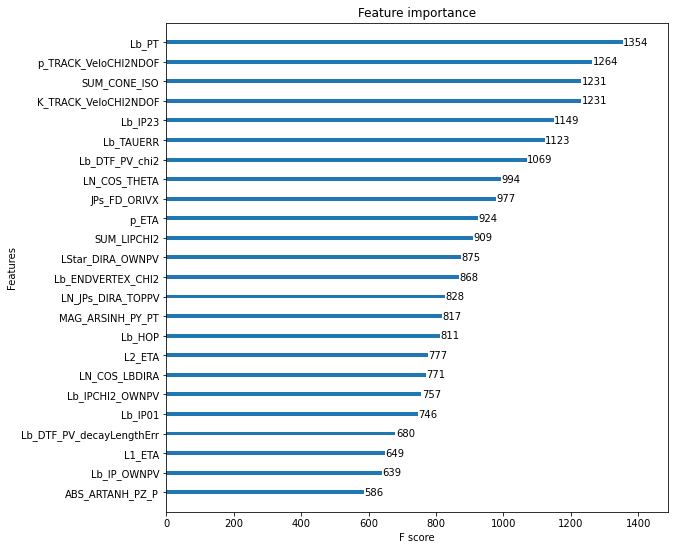

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
xgb.plot_importance(xgb_clf, ax=ax, grid=False)
#plt.savefig(f'../images/MLModels/feature_importance_xgb_v{version}.png')
plt.show()

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


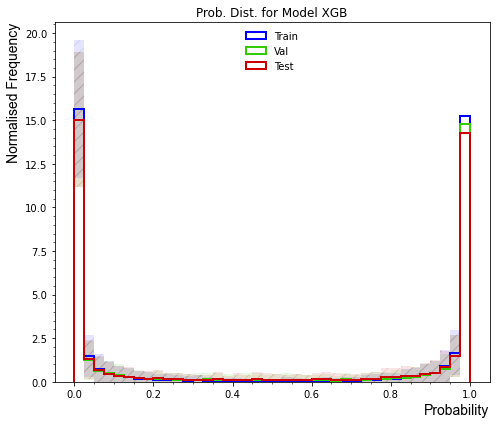

In [9]:
import plotter as ptr

train = X_train.copy()
train['category'] = y_train
val = X_val.copy()
val['category'] = y_val
test = X_test.copy()
test['category'] = y_test

myPlotter = ptr.ProbabilityDistribution(train, val, test)
myPlotter.plot_multiple(xgb_clf, 'XGB')

In [14]:
from sklearn.metrics import roc_curve

y_score = xgb_clf.predict_proba(X_test)[:,1]
my_roc = roc_curve(y_test, y_score, pos_label=1)

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [28]:
from joblib import load
my_knn_model = load('../classification_methods/models/KNN_6.0.3.joblib')
knn_roc = roc_curve(y_test, my_knn_model.predict_proba(X_test)[:,1], pos_label=1)

In [30]:
import tensorflow as tf
my_nn_model = tf.keras.models.load_model(f'../neural_network/models/v{version}')
nn_roc = roc_curve(y_test, my_nn_model.predict(X_test), pos_label=1)

2022-03-04 16:31:43.339980: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-04 16:31:43.361889: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-04 16:31:44.122243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-04 16:31:44.135648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


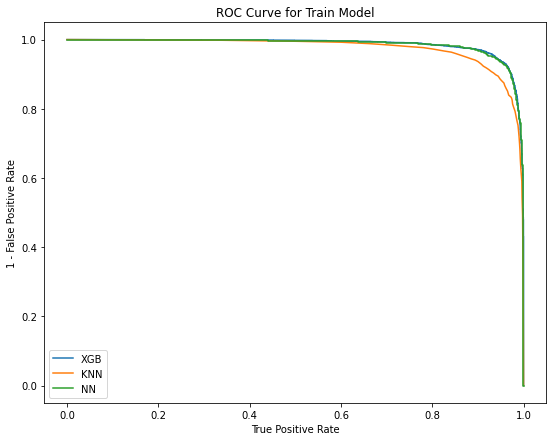

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.plot(my_roc[1], 1-my_roc[0], label='XGB')
ax.plot(knn_roc[1], 1-knn_roc[0], label='KNN')
ax.plot(nn_roc[1], 1-nn_roc[0], label='NN')
plt.xlabel('True Positive Rate')
plt.ylabel('1 - False Positive Rate')
plt.title('ROC Curve for Train Model')
plt.legend()
plt.show()